In [18]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import MDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_selection import chi2
import os, sys
import glob
import gensim
from gensim.corpora import Dictionary
from gensim.similarities import MatrixSimilarity
from gensim.models import ldamodel, doc2vec, LsiModel 
import nltk
# nltk.download('punkt')
import string
import csv
import math
import statistics
import datetime
from nltk.corpus import stopwords
from nltk.util import ngrams
# nltk.download('stopwords')
from collections import OrderedDict, Counter, namedtuple
import networkx as nx
import matplotlib.pyplot as plt
from networkx.readwrite import json_graph
from bokeh.plotting import figure, show, output_file
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.layouts import row, column
from progress.bar import IncrementalBar
import warnings
warnings.filterwarnings('ignore')
nlp = spacy.load('en_core_web_lg')


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [25]:
def count_vec(docs, nrange):
    print(docs)
    count_model = CountVectorizer(ngram_range=(nrange)) # default unigram model
    X = count_model.fit_transform(docs.tokenized_text)
    Xc = (X.T * X)
    # Xc.setdiag(0)
    lsa = TruncatedSVD(n_components=X.shape[1]-1, n_iter=10)
    lsaOut = lsa.fit(X)
    xs, ys = lsaOut.components_[0], lsaOut.components_[1]
    vocab = count_model.vocabulary_
    labels = [x.strip() for x,y in vocab.items()]
    feature_names = count_model.get_feature_names()
    best_features = [feature_names[i] for i in lsaOut.components_[0].argsort()[::-1]]
    print(labels)
#     %matplotlib notebook
    for i in range(len(xs)):
        # print(labels[i], xs[i], ys[i])
        plt.scatter(xs[i], ys[i])
        plt.annotate(best_features[i], (xs[i], ys[i]))
    plt.show()
    # print(pd.DataFrame(X.toarray(), columns=count_model.get_feature_names()[0:100]))
    feature_array = np.array(count_model.get_feature_names())
    tfidf_sorting = np.argsort(X.toarray()).flatten()[::-1]
    
    # best_features = [feature_names[i] for i in lsaOut.components_[0].argsort()[::-1]]
    print(best_features[:100])
    n = 100
    top_n = feature_array[tfidf_sorting][:n]
    print(list(top_n))

date                                                 1960-August-14
tokenized_text    [arab observer index vol 1- august arab world ...
term                                        katanga tshombe belgian
page_number                                                       3
word_counts                                                       3
Name: 0, dtype: object
['arab', 'observer', 'index', 'vol', 'august', 'world', 'unity', 'enhanced', 'danger', 'new', 'libya', 'published', 'weekly', 'affairs', 'towards', 'better', 'relations', 'turkey', 'development', 'scientific', 'lines', 'agricultural', 'mission', 'editor', 'in', 'chief', 'mahmoud', 'amr', 'publisher', 'middle', 'east', 'research', 'centre', 'political', 'roundup', 'security', 'council', 'resolution', 'belgium', 'exerts', 'pressure', 'laos', 'cuba', 'west', 'third', 'bloc', 'distributed', 'national', 'publications', 'house', 'sharia', 'mansour', 'cairo', 'price', 'pt', 'african', 'continent', 'triumph', 'peace', 'annual', 'subscrip

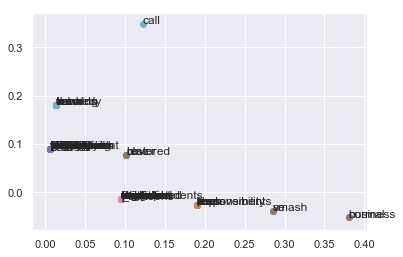

['reproduced', 'll', 'akhbar', 'al', 'smash', 've', 'us', 'arabs', 'russia', 'call', 'shah', 'arab', 'peace', 'world', 'israel', '_cartoons', 'drum', 'e1', 'nothing', 'nixon', 'massa', 'anyone', 'long', 'belgian', 'ben', 'kennedy', 'born', 'boy', 'imperialism', 'hollow', 'golda', 'girl', 'correspondents', 'farah', 'diba', 'observa', 'yom', 'said', 'tshombe', 'turned', 'recognising', 'seek', 'libya', 'canal', 'observer', 'belgium', 'east', 'new', 'affairs', 'central', 'centre', 'concerns', 'chief', 'published', 'continent', 'conditions', 'cairo', 'third', 'cotton', 'council', 'cover', 'cuba', 'danger', 'development', 'towards', 'triumph', 'business', 'unity', 'african', 'agricultural', 'west', 'weekly', 'amr', 'annual', 'vol', 'argument', 'trade', 'august', 'bank', 'banking', 'turkey', 'better', 'bloc', 'distributed', 'suez', 'economy', 'subscription', 'resolution', 'mahmoud', 'mansour', 'relations', 'middle', 'mission', 'national', 'regulate', 'normal', 'radio', 'opinion', 'page', 'pub

In [26]:
def custom_tokenize(text):
    if not text:
#       print('The text to be tokenized is a None type. Defaulting to blank string.')
        text = ''
    return nltk.word_tokenize(text)

def join_token_terms(rows):
    texts = rows.astype(str).tolist()
    final_doc = []
    types = ['LOC', 'GPE']
    for t in texts: 
        spacy_terms = ''
        page_terms = ''
        spacy_text = nlp(t)
        tokens = custom_tokenize(t)
        for t in tokens:
            if t in string.punctuation:
                continue
            elif t in stopwords.words('english'):
                continue
                
            elif t.isdigit():
                continue
            else:
                
                page_terms += t.lower() + ' '
        
        final_doc.append(page_terms)
    return final_doc

df = pd.read_csv('../data/combined_all_data_ner_congo.csv')
d = df[0:3]
df_tokenized = d.groupby(['date'])['tokenized_text'].apply(join_token_terms).reset_index()
df_pages = d.groupby(['date'])['page_number'].count().reset_index()
df_terms = d.groupby(['date'])['term'].apply(' '.join).reset_index()
df_counts = d.groupby(['date'])['word_counts'].sum().reset_index()

dl = pd.merge(df_tokenized, df_terms, on=['date'])
dn = pd.merge(dl, df_pages, on=['date'])
final_df = pd.merge(dn, df_counts, on=['date'])
    # print(final_df)
for i, row in final_df.iterrows():
    #     print(row)

    count_df = count_vec(row, (1,1))

In [28]:
l1 = set(['reproduced', 'll', 'akhbar', 'al', 'smash', 've', 'us', 'arabs', 'russia', 'call', 'shah', 'arab', 'peace', 'world', 'israel', '_cartoons', 'drum', 'e1', 'nothing', 'nixon', 'massa', 'anyone', 'long', 'belgian', 'ben', 'kennedy', 'born', 'boy', 'imperialism', 'hollow', 'golda', 'girl', 'correspondents', 'farah', 'diba', 'observa', 'yom', 'said', 'tshombe', 'turned', 'recognising', 'seek', 'canal', 'east', 'libya', 'belgium', 'observer', 'new', 'conditions', 'central', 'centre', 'chief', 'concerns', 'published', 'continent', 'towards', 'cotton', 'council', 'cover', 'cuba', 'danger', 'development', 'suez', 'third', 'trade', 'cairo', 'business', 'african', 'agricultural', 'west', 'weekly', 'amr', 'annual', 'vol', 'unity', 'argument', 'august', 'bank', 'banking', 'turkey', 'better', 'bloc', 'triumph', 'subscription', 'distributed', 'economy', 'story', 'publications', 'mahmoud', 'mansour', 'relations', 'middle', 'mission', 'national', 'regulate', 'normal', 'radio', 'opinion', 'page', 'publisher']) 
l2 = set(['reproduced', 'll', 'akhbar', 'al', 'arabs', 'russia', 'call', 'smash', 'us', 've', 'shah', 'nixon', 'massa', 'golda', 'long', 'world', 'kennedy', 'israel', 'nothing', 'imperialism', 'hollow', 'yom', 'girl', 'farah', 'peace', 'e1', 'drum', 'diba', 'correspondents', 'boy', 'born', 'ben', 'belgian', 'arab', 'anyone', 'observa', '_cartoons', 'recognising', 'tshombe', 'seek', 'said', 'turned', 'third', 'canal', 'central', 'centre', 'chief', 'concerns', 'conditions', 'continent', 'published', 'cairo', 'cotton', 'council', 'cover', 'cuba', 'danger', 'development', 'suez', 'distributed', 'towards', 'trade', 'business', 'unity', 'affairs', 'african', 'agricultural', 'west', 'weekly', 'amr', 'annual', 'vol', 'argument', 'story', 'august', 'bank', 'banking', 'turkey', 'belgium', 'better', 'bloc', 'triumph', 'subscription', 'economy', 'east', 'radio', 'mansour', 'relations', 'middle', 'mission', 'national', 'new', 'regulate', 'normal', 'observer', 'research', 'opinion', 'page', 'publisher', 'political'])
l1-l2

{'libya', 'mahmoud', 'publications'}

In [77]:
def tfidf_vec(docs, nrange):
    print(docs)
    count_model = TfidfVectorizer(ngram_range=(nrange)) # default unigram model
    X = count_model.fit_transform(docs.tokenized_text)
    Xc = (X.T * X)
    # Xc.setdiag(0)
    lsa = TruncatedSVD(n_components=2, n_iter=10)
    lsaOut = lsa.fit(X)
    xs, ys = lsaOut.components_[0], lsaOut.components_[1]
    vocab = count_model.vocabulary_
    labels = [x.strip() for x,y in vocab.items()]
    feature_names = count_model.get_feature_names()
    best_features = [feature_names[i] for i in lsaOut.components_[0].argsort()[::-1]]
#     print(labels)
#     %matplotlib notebook
#     for i in range(len(xs)):
#         # print(labels[i], xs[i], ys[i])
#         plt.scatter(xs[i], ys[i])
#         plt.annotate(best_features[i], (xs[i], ys[i]))
#     plt.show()
    # print(pd.DataFrame(X.toarray(), columns=count_model.get_feature_names()[0:100]))
    feature_array = np.array(count_model.get_feature_names())
    tfidf_sorting = np.argsort(X.toarray()).flatten()[::-1]
    
    # best_features = [feature_names[i] for i in lsaOut.components_[0].argsort()[::-1]]
    print(best_features[:100], len(best_features))
    n = 100
    top_n = feature_array[tfidf_sorting][:n]
    print(list(top_n), len(feature_array))

In [79]:
def custom_tokenize(text):
    if not text:
#       print('The text to be tokenized is a None type. Defaulting to blank string.')
        text = ''
    return nltk.word_tokenize(text)

def join_token_terms(rows):

    texts = rows.astype(str).tolist()
    final_doc = []
    types = ['LOC', 'GPE']
    for t in texts: 
        spacy_terms = ''
        page_terms = ''
        spacy_text = nlp(t)
        tokens = custom_tokenize(t)
        for t in tokens:
            if t in string.punctuation:
                continue
            elif t in stopwords.words('english'):
                continue
                
            elif t.isdigit():
                continue
            else:
                
                page_terms += t.lower() + ' '
        
        final_doc.append(page_terms)
    return final_doc

def get_texts(rows):

    texts = rows.tolist()
    return [texts[0]]

df = pd.read_csv('../data/combined_all_data_ner_congo.csv')
d = df[0:100]
df_tokenized = d.groupby(['date', 'page_number'])['tokenized_text'].apply(get_texts).reset_index()
df_tokens = df_tokenized.groupby(['date'])['tokenized_text'].apply(join_token_terms).reset_index()

df_pages = df_tokenized.groupby(['date'])['page_number'].count().reset_index()
df_terms = d.groupby(['date'])['term'].apply(' '.join).reset_index()
df_counts = d.groupby(['date'])['word_counts'].sum().reset_index()

dl = pd.merge(df_tokens, df_terms, on=['date'])
dn = pd.merge(dl, df_pages, on=['date'])
final_df = pd.merge(dn, df_counts, on=['date'])
final_df.date.unique()
for i, row in final_df.iterrows():
    count_df = tfidf_vec(row, (1,2))

date                                                 1960-August-14
tokenized_text    [`` arab observer index vol 1- august arab wor...
term              katanga tshombe belgian patrice congo lumumba ...
page_number                                                      14
word_counts                                                     175
Name: 0, dtype: object
['united', 'nations', 'forces', 'congo', 'belgium', 'united nations', 'would', 'tshombe', 'katanga', 'belgian', 'government', 'independence', 'france', 'world', 'african', 'security', 'province', 'country', 'shah', 'western', 'countries', 'states', 'hammarskjoeld', 'council', 'mr', 'security council', 'said', 'powers', 'influence', 'israel', 'may', 'august', 'arab', 'peace', 'resolution', 'new', 'people', 'enter', 'lumumba', 'troops', 'al', 'belgian forces', 'one', 'na', 'fact', 'mission', 'un', 'success', 'order', 'general', 'announced', 'political', 'kennedy', 'must', 'in', 'pressure', 'ing', 'situation', 'time', 'mr kennedy', 

In [33]:
l3 = set(['reproduced', 'll', 'akhbar', 'al', 'shah', 'russia', 'call', 'smash', 'arabs', 'us', 've', 'recognising', 'massa', 'long', 'farah', 'kennedy', 'imperialism', 'hollow', 'golda', 'said', 'nixon', 'girl', 'yom', 'seek', 'e1', 'observa', 'drum', 'diba', 'correspondents', 'boy', 'born', 'ben', 'tshombe', 'belgian', 'turned', 'anyone', 'nothing', '_cartoons', 'arab', 'world', 'israel', 'peace', 'libya', 'observer', 'new', 'belgium', 'canal', 'east', 'affairs', 'concerns', 'central', 'third', 'cairo', 'centre', 'chief', 'suez', 'conditions', 'continent', 'cotton', 'council', 'cover', 'cuba', 'danger', 'development', 'business', 'publications', 'towards', 'trade', 'african', 'agricultural', 'west', 'weekly', 'amr', 'annual', 'vol', 'unity', 'argument', 'august', 'bank', 'banking', 'turkey', 'triumph', 'better', 'bloc', 'distributed', 'subscription', 'economy', 'story', 'sharia', 'relations', 'mahmoud', 'mansour', 'regulate', 'middle', 'mission', 'national', 'radio', 'normal', 'publisher', 'published'])
l4 = set(['reproduced', 'll', 'akhbar', 'al', 've', 'us', 'arabs', 'smash', 'shah', 'call', 'russia', 'yom', 'kennedy', 'hollow', 'imperialism', 'massa', 'long', 'nixon', 'nothing', 'golda', 'e1', 'girl', 'farah', 'recognising', 'drum', 'diba', 'correspondents', 'boy', 'born', 'ben', 'belgian', 'anyone', 'observa', '_cartoons', 'said', 'tshombe', 'turned', 'seek', 'world', 'israel', 'peace', 'arab', 'regulate', 'continent', 'centre', 'chief', 'concerns', 'conditions', 'cotton', 'towards', 'canal', 'council', 'cover', 'cuba', 'danger', 'development', 'third', 'distributed', 'suez', 'central', 'business', 'trade', 'cairo', 'affairs', 'african', 'agricultural', 'west', 'weekly', 'amr', 'annual', 'vol', 'unity', 'argument', 'august', 'bank', 'banking', 'belgium', 'turkey', 'better', 'bloc', 'triumph', 'east', 'subscription', 'enhanced', 'economy', 'opinion', 'mission', 'national', 'new', 'resolution', 'normal', 'research', 'relations', 'observer', 'page', 'responsibility', 'political', 'press', 'pressure', 'price'])
l4-l3

{'enhanced',
 'opinion',
 'page',
 'political',
 'press',
 'pressure',
 'price',
 'research',
 'resolution',
 'responsibility'}

In [36]:
l1-l2

{'libya', 'mahmoud', 'publications'}

In [37]:
l1-l3

{'opinion', 'page'}

In [38]:
l1-l4

{'libya',
 'mahmoud',
 'mansour',
 'middle',
 'publications',
 'published',
 'publisher',
 'radio',
 'story'}

In [39]:
l2-l1

{'affairs', 'political', 'research'}

In [40]:
l2-l3

{'opinion', 'page', 'political', 'research'}

In [41]:
l2-l4

{'mansour', 'middle', 'published', 'publisher', 'radio', 'story'}

In [42]:
l3-l1

{'affairs', 'sharia'}

In [43]:
l3-l2

{'libya', 'mahmoud', 'publications', 'sharia'}

In [44]:
l3-l4

{'libya',
 'mahmoud',
 'mansour',
 'middle',
 'publications',
 'published',
 'publisher',
 'radio',
 'sharia',
 'story'}

In [48]:
final_df

,date,tokenized_text,term,page_number,word_counts
0,1960-August-14,[arab observer index vol 1- august arab world ...,katanga tshombe belgian,3,3
